In [1]:
import os
os.chdir('..')
import numpy as np
import datajoint as dj

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

Connecting chris@localhost:3306


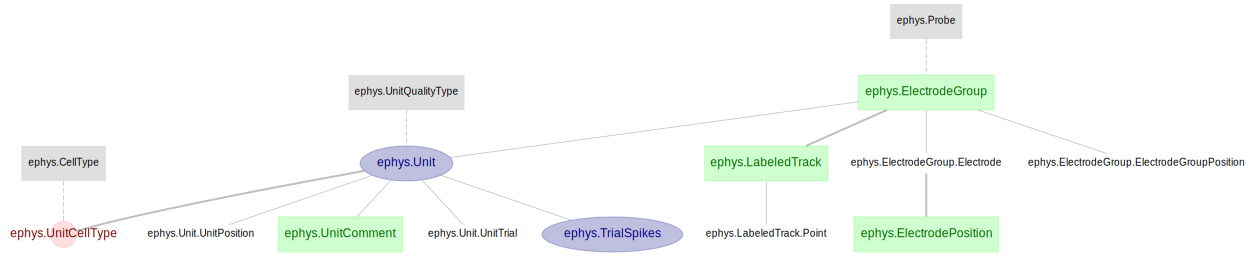

In [4]:
from pipeline import ephys
dj.ERD(ephys)

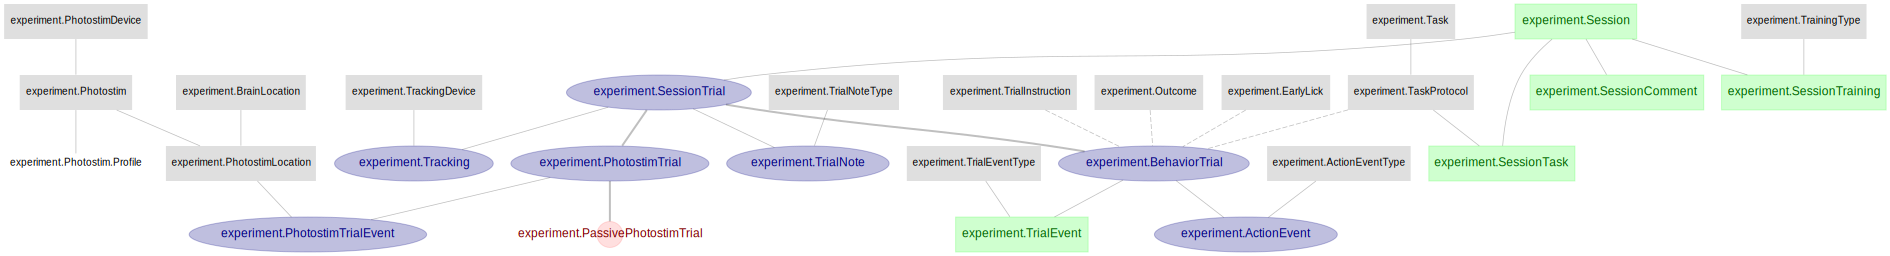

In [5]:
from pipeline import experiment
dj.ERD(experiment)

In [6]:
sess_key = {'subject_id': 90211, 'session': 1, 'electrode_group': 1}

In [7]:
experiment.BehaviorTrial() & sess_key

subject_id institution 6 digit animal ID,session session number,trial trial number,task task type,task_protocol task protocol,trial_instruction,early_lick,outcome
90211,1,0,audio delay,1,right,no early,ignore
90211,1,1,audio delay,1,right,no early,ignore
90211,1,2,audio delay,1,right,no early,ignore
90211,1,3,audio delay,1,left,no early,ignore
90211,1,4,audio delay,1,left,no early,ignore
90211,1,5,audio delay,1,left,no early,ignore
90211,1,6,audio delay,1,left,no early,ignore


In [8]:
experiment.PhotostimTrialEvent() & sess_key

subject_id institution 6 digit animal ID,session session number,trial trial number,photostim_device,photo_stim,hemisphere,brain_area,brainloc_id id within BrainArea,photostim_event_time (s) from trial start,power Maximal power (mW)
90211,1,0,OBIS470,0,both,ALM,0,0.500,0.000
90211,1,1,OBIS470,0,both,ALM,0,0.500,0.000
90211,1,2,OBIS470,0,both,ALM,0,0.500,0.000
90211,1,3,OBIS470,0,both,ALM,0,0.500,0.000
90211,1,4,OBIS470,0,both,ALM,0,0.500,0.000
90211,1,5,OBIS470,0,both,ALM,0,0.500,0.000
90211,1,6,OBIS470,0,both,ALM,0,0.500,0.000


In [9]:
ephys.Unit() & dict(sess_key, unit_quality='good')

subject_id institution 6 digit animal ID,session session number,electrode_group Electrode_group is like the probe,unit,unit_uid unique across sessions/animals,unit_quality,unit_channel channel on the electrode for which the unit has the largest amplitude,spike_times (s),waveform average spike waveform
90211,1,1,0,0,good,nan,=BLOB=,=BLOB=
90211,1,1,4,4,good,nan,=BLOB=,=BLOB=
90211,1,1,9,9,good,nan,=BLOB=,=BLOB=
90211,1,1,10,10,good,nan,=BLOB=,=BLOB=
90211,1,1,14,14,good,nan,=BLOB=,=BLOB=
90211,1,1,17,17,good,nan,=BLOB=,=BLOB=
90211,1,1,20,20,good,nan,=BLOB=,=BLOB=


In [10]:
unit_key = dict(sess_key, unit=4)

In [39]:
def plot_psth(unit_key): # {'subject_id', 'session', 'electrode_group', 'unit'}
    
    sess_key = unit_key # hack
    behaviorT = experiment.BehaviorTrial()
    photostimT = experiment.PhotostimTrialEvent()
    
    max_trial_off = 500
    binSize=0.04
    plt_xmin=-3
    plt_xmax=3
    plt_ymin=0
    plt_ymax=None  # dynamic per unit
    
    # query behavior results
    contraH=(behaviorT & sess_key & 'outcome = "hit"' & 'trial_instruction = "right"' & 'early_lick = "no early"' & 'trial > 150')
    ipsiH=(behaviorT & sess_key & 'outcome = "hit"' & 'trial_instruction = "left"' & 'early_lick = "no early"' & 'trial > 150')

    contraE=(behaviorT & sess_key & 'outcome = "miss"' & 'trial_instruction = "right"' & 'early_lick = "no early"' & 'trial > 150')
    ipsiE=(behaviorT & sess_key & 'outcome = "miss"' & 'trial_instruction = "left"' & 'early_lick = "no early"' & 'trial > 150')

    # fetch corresponding spikes/trials
    contraH_spikes, contraH_trials = ((ephys.TrialSpikes() & unit_key & contraH) - photostimT).fetch('spike_times', 'trial')
    ipsiH_spikes, ipsiH_trials = ((ephys.TrialSpikes() & unit_key & ipsiH) - photostimT).fetch('spike_times', 'trial')
    contraE_spikes, contraE_trials = ((ephys.TrialSpikes() & unit_key & contraE) - photostimT).fetch('spike_times', 'trial')
    ipsiE_spikes, ipsiE_trials = ((ephys.TrialSpikes() & unit_key & ipsiE) - photostimT).fetch('spike_times', 'trial')

    # adjust dimensions for plotting ([trial spikes, ...] v [trialno[len(trial spikes)], ...])
    flat_contraH_spikes = np.concatenate(contraH_spikes)
    flat_contraH_trials = np.concatenate([[trial] * len(spikes) for spikes, trial in zip(contraH_spikes, contraH_trials)])

    flat_ipsiH_spikes = np.concatenate(ipsiH_spikes)
    flat_ipsiH_trials = np.concatenate([[trial] * len(spikes) for spikes, trial in zip(ipsiH_spikes, ipsiH_trials)])
    
    flat_contraE_spikes = np.concatenate(contraE_spikes)
    flat_contraE_trials = np.concatenate([[trial] * len(spikes) for spikes, trial in zip(contraE_spikes, contraE_trials)])

    flat_ipsiE_spikes = np.concatenate(ipsiE_spikes)
    flat_ipsiE_trials = np.concatenate([[trial] * len(spikes) for spikes, trial in zip(ipsiE_spikes, ipsiE_trials)])

    # compute psth for each group
    psth_contraH=list(np.histogram(flat_contraH_spikes, bins=np.arange(plt_xmin, plt_xmax, binSize)))
    psth_contraH[0]=psth_contraH[0]/len(contraH)/binSize
    
    psth_ipsiH=list(np.histogram(flat_ipsiH_spikes, bins=np.arange(plt_xmin, plt_xmax, binSize)))
    psth_ipsiH[0]=psth_ipsiH[0]/len(ipsiH)/binSize
    
    psth_contraE=list(np.histogram(flat_contraE_spikes, bins=np.arange(plt_xmin, plt_xmax, binSize)))
    psth_contraE[0]=psth_contraE[0]/len(contraE)/binSize
    
    psth_ipsiE=list(np.histogram(flat_ipsiE_spikes, bins=np.arange(plt_xmin, plt_xmax, binSize)))
    psth_ipsiE[0]=psth_ipsiE[0]/len(ipsiE)/binSize    

    
    # Correct Trial Raster Plots (plt.plot(spike_times_for_unit, trial_number_for_spike))
    plt.figure()
    ax=plt.subplot(411)
    plt.plot(flat_contraH_spikes, flat_contraH_trials + max_trial_off, 'b.', markersize=1)
    plt.plot(flat_ipsiH_spikes, flat_ipsiH_trials, 'r.', markersize=1)
    ax.set_axis_off()
    ax.set_xlim([plt_xmin, plt_xmax])
    ax.axvline(0,0,1, ls='--')
    ax.axvline(-1.2,0,1, ls='--')
    ax.axvline(-2.4,0,1, ls='--')
    
    # Correct Trial Histogram Plots    
    ax = plt.subplot(412)
    plt.plot(psth_contraH[1][1:], psth_contraH[0], 'b')
    plt.plot(psth_ipsiH[1][1:], psth_ipsiH[0], 'r')

    plt.ylabel('spikes/s')
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    plt_ymax = np.max([psth_contraH[0], psth_ipsiH[0]])
    ax.set_xlim([plt_xmin, plt_xmax])
    ax.set_ylim([plt_ymin, plt_ymax])
    ax.set_xticklabels([])
    ax.axvline(0,0,1, ls='--')
    ax.axvline(-1.2,0,1, ls='--')
    ax.axvline(-2.4,0,1, ls='--')
    plt.title('Correct trials')
    
    # Error Trial Raster Plots
    ax = plt.subplot(413)
    plt.plot(flat_contraE_spikes, flat_contraE_trials + max_trial_off, 'b.', markersize=1)
    plt.plot(flat_ipsiE_spikes, flat_ipsiE_trials, 'r.', markersize=1)
    ax.set_axis_off()
    ax.set_xlim([plt_xmin, plt_xmax])
    ax.axvline(0,0,1, ls='--')
    ax.axvline(-1.2,0,1, ls='--')
    ax.axvline(-2.4,0,1, ls='--')
    
    # Error Trial Histogram Plots
    ax = plt.subplot(414)
    plt.plot(psth_contraE[1][1:], psth_contraE[0]/len(contraE)/binSize, 'b')
    plt.plot(psth_ipsiE[1][1:], psth_ipsiE[0]/len(ipsiE)/binSize, 'r')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    plt_ymax = np.max([psth_contraE[0], psth_ipsiE[0]])
    ax.set_xlim([plt_xmin, plt_xmax])
    ax.set_ylim([plt_ymin, plt_ymax])
    ax.axvline(0,0,1, ls='--')
    ax.axvline(-1.2,0,1, ls='--')
    ax.axvline(-2.4,0,1, ls='--')
    
    plt.title('Error trials')
    plt.xlabel('Time to go cue (s)')
    plt.show()
    
    return locals()

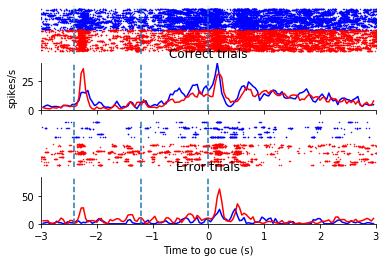

In [40]:
l = plot_psth(unit_key)